In [16]:

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn
import numpy as np
import glob
import time
import gzip
import math

code={b"HIS":b"0",
        b"ASP":b"1",
        b"LYS":b"2",
        b"TYR":b"3",
        b"GLU":b"4",
        b"CYS":b"5"}


import torch.nn.functional
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=500):
        super().__init__()
        #self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return x#self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs
    
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyRegressor(nn.Module):
    def __init__(self, in_channels=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, 1, padding=1)
            #nn.ReLU(),
            #nn.Conv2d(16, 32, 3, padding=1),
            #nn.ReLU()
        #)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.out  = nn.Linear(1, 1)

    def forward(self, x):
        x = self.conv(x)
        #x = self.pool(x).flatten(1)   # (B, 32)
        return x#self.out(x)

       # (B, 1)
    
model = TinyRegressor()
#lin=nn.Linear(6,1)
A = PositionalEncoding(1)
mha = SimpleMultiheadAttention(1,1)

net=EGNN_Network(dim=3,
    depth=6,
    num_positions=500, #no
    num_tokens=78,
    #num_edge_tokens=1,
    #global_linear_attn_every=1,
    #global_linear_attn_dim_head=8,
    #num_global_tokens=2,
    #adj_dim=3,
    dropout=0.1,
    coor_weights_clamp_value = 2,
    norm_coors=True)
    #norm_coors=True)

A = PositionalEncoding(3)
mha = SimpleMultiheadAttention(3,1) #6 is the dim
tlosses, losses=[],[]
pks=[]
outs=[]
ts=[]
paths=np.char.array(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))
#val=paths[np.random.random_integers(low=0,high=len(paths)-2,size=np.int(0.4*len(paths)))]
#train=np.char.array(list(set(paths).difference(set(val))))
#np.savez_compressed("/home/jrhoernschemeyer/Desktop/data_prep/split.npz",val=val, train=train)

optimizer= torch.optim.Adam(list(net.parameters()) + list(mha.parameters()), lr=.1)
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
to=time.time()

for i in range(1):
    #try:
    
    train = list(np.array(train)[np.random.permutation(len(train))])
    print("epoch",i)
    for path in train:
        batch_loss=0
        losses=[]
        pdb=np.char.encode(path[-8:-4])
        mha.train()
        net.train()
        #model.train()
        optimizer.zero_grad()
        a=np.load(path,allow_pickle=True) #TODO
        zs,xs,targets=a["z"],a["pos"],a["pks"]
        #ids=a["ids"]
        a = zs.shape[0]
        #shuffle
        idx = np.random.permutation(a)
        zs,xs,targets=zs[idx],xs[idx],targets[idx]
        #ids=ids[idx]
        #lmbda = lambda epoch: 0.95
        #scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
        #for epoch in range(100):
        
        for z,x,y in zip(zs,xs,targets):
            try:
                x=torch.tensor(x).unsqueeze(0)
                z=torch.tensor(z[0].astype(np.int32)).unsqueeze(0)
            except:
                print(pdb)
                continue

            #remove H #TODO
            #mask = (z != 1)
            #z = z[mask]
            #x = x[mask]

            out1=net(z,x)[0]

            #print(out)
            x = torch.nn.functional.normalize(mha(A(torch.nn.functional.normalize(out1[0]))))      #  shape: (H, W, C) = (9, 9, 6)
            x = torch.nn.Hardswish()(x)
            #print(x)
            #x = x.permute(2, 0, 1).unsqueeze(0)   # → (B, C, H, W) = (1, 6, 9, 9)
            if type(y) != np.float32:
                print(y,pdb)
            #pk = model(x)    
            #print(pk)    
            #out=mha(A(out[0][0]))
            #out.permute(2, 0, 1).unsqueeze(0) 
            #x=torch.nn.FeatureAlphaDropout(x)
            #out=torch.nn.LogSoftmax()(x)
            pk=torch.sum(x)
            #out=torch.nn.Hardswish(x)
            #pk=torch.sum(model(x))
            #pk=torch.mean(x)
            #pk=torch.sum(torch.linalg.matrix_norm(out))
            pks.append(pk)
            #outs.append(out)
            #ts.append(y)
            #print(id, pk, y)
            #print(loss)
            #print("why")
            y=torch.tensor(y)
            
            loss = criterion(pk,y)
            
            tlosses.append(np.round(loss.item(),3))
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.1)
            optimizer.step()
            #print(pk)
            #if y.size == 0:
                #print(pdb)
        #print(loss)
            #pk=torch.sum(out[0],dim=1)/(torch.max(out[0]))
            #out=lin(pk)
        #batch_loss.backward()
        #optimizer.step()
        #batch_loss = 0
    
    

epoch 0
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6q5r'
b'6e00'
b'3ftl'


KeyboardInterrupt: 

In [18]:
np.savez_compressed("/home/jrhoernschemeyer/Desktop/data_prep/17mayjuypter41mins.npz",losses=tlosses, pks=pks, train=train)
#25sec

In [19]:
torch.save(net.state_dict(),"/home/jrhoernschemeyer/Desktop/data_prep/17may")
torch.save(mha.state_dict(),"/home/jrhoernschemeyer/Desktop/data_prep/17maymha")#nettest")  

rsync -e 'ssh -i /home/jrhoernschemeyer/.ssh/id_ed25519.pub' "/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz" becjessi@blogin.nhr.zib.de:~/inputs

In [ ]:
paths=np.char.array(glob.glob("/home/jrhoernschemeyer/Desktop/data_prep/inputs/*.npz"))
val=paths[np.random.random_integers(low=0,high=len(paths)-2,size=np.int(0.4*len(paths)))]
train=np.char.array(list(set(paths).difference(set(val))))

In [17]:
print(train)

['/home/jrhoernschemeyer/Desktop/data_prep/inputs/2x0r.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/2mbw.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/4za5.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/3p8n.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/1fw4.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/1j7v.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/3fhk.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/4ev0.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/2f7w.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/1py3.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/3k4p.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/6kju.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/6sw0.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/1o5h.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/4l6r.npz', '/home/jrhoernschemeyer/Desktop/data_prep/inputs/2uuk.npz', '/home/jrhoernschemeyer/Desktop/data_pr

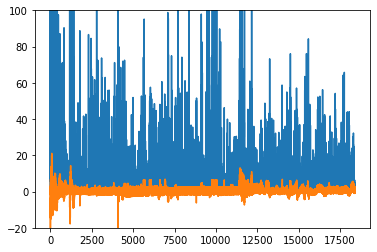

In [7]:
from matplotlib import pyplot as plt
plt.plot(tlosses)
plt.ylim(-20,100)
plt.plot(pks)

Text(0.5, 1.0, '41 mins')

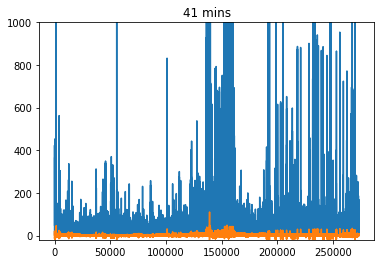

In [23]:
from matplotlib import pyplot as plt
plt.plot(tlosses)
plt.ylim(-20,1000)
plt.plot(pks)
plt.title("41 mins")

In [ ]:
out

In [ ]:
from matplotlib import pyplot as plt
plt.plot(tlosses)
plt.ylim(-20,100)
plt.plot(pks)

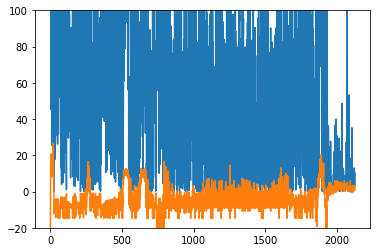

In [15]:
from matplotlib import pyplot as plt
plt.plot(tlosses)
plt.ylim(-20,100)
plt.plot(pks)

In [ ]:
to=time.time()
for i in range(1):
    #try:
    
    train = list(np.array(train)[np.random.permutation(len(train))])
    print("epoch",i)
    for path in train:
        batch_loss=0
        losses=[]
        pdb=np.char.encode(path[-8:-4])
        mha.train()
        net.train()
        model.train()
        optimizer.zero_grad()
        a=np.load(path,allow_pickle=True)
        zs,xs,targets=a["z"],a["pos"],a["pks"]
        #ids=a["ids"]
        n = zs.shape[0]
        #shuffle
        idx = np.random.permutation(n)
        zs,xs,targets=zs[idx],xs[idx],targets[idx]
        #ids=ids[idx]
        #lmbda = lambda epoch: 0.95
#scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
#for epoch in range(100):
        
        for z,x,y in zip(zs,xs,targets):

            x=torch.tensor(x).unsqueeze(0)
            z=torch.tensor(z[0].astype(np.int32)).unsqueeze(0)

            #x=torch.tensor(list(x)).unsqueeze(0)
            #z=torch.tensor(list(z),dtype=torch.int32)
            #remove H
            #mask = (z != 1)
            #z = z[mask]
            #x = x[mask]

            out1=net(z,x)[0]

            #print(out)
            x = torch.nn.functional.normalize(mha(A(torch.nn.functional.normalize(out1)[0])))        #  shape: (H, W, C) = (9, 9, 6)
            x = torch.nn.Hardswish()(x)
            #print(x)
            #x = x.permute(2, 0, 1).unsqueeze(0)   # → (B, C, H, W) = (1, 6, 9, 9)

            #pk = model(x)    
            #print(pk)    
            #out=mha(A(out[0][0]))
            #out.permute(2, 0, 1).unsqueeze(0) 
            #x=torch.nn.FeatureAlphaDropout(x)
            #out=torch.nn.LogSoftmax()(x)
            pk=torch.sum(x)
            #out=torch.nn.Hardswish(x)
            #pk=torch.sum(model(x))
            #pk=torch.mean(x)
            #pk=torch.sum(torch.linalg.matrix_norm(out))
            pks.append(pk)
            #outs.append(out)
            #ts.append(y)
            #print(id, pk, y)
            #print(loss)
            #print("why")

            loss = criterion(pk,torch.tensor(y))
            
            tlosses.append(np.round(loss.item(),3))
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.1)
            optimizer.step()
     
        print(loss.item())
            #pk=torch.sum(out[0],dim=1)/(torch.max(out[0]))
            #out=lin(pk)
        #batch_loss.backward()
        #optimizer.step()
        #batch_loss = 0
    

epoch 0
3.904433488845825
0.4998989999294281
0.2384834587574005
0.9409250617027283
0.5221214294433594
0.4049316644668579
0.4485647976398468
0.06208768114447594
4.24570894241333
0.009493590332567692
0.3172762095928192
2.2620115280151367
4.071029186248779
0.23876763880252838
0.6539654731750488
0.021007729694247246
0.5504134297370911
1.2996348142623901
1.6526670455932617
6.220534324645996
0.11284943670034409
1.6601531505584717
0.2963581085205078
0.419650673866272
0.3867059648036957
5.189545154571533
1.011147141456604
9.150588035583496
2.2603580951690674
0.724746823310852
0.43881839513778687
2.7354037761688232
0.00043008464854210615
0.3968296945095062
2.151829242706299
0.10196607559919357
3.2933077812194824
8.138884544372559
3.6243419647216797
1.7957205772399902
0.3612591326236725
0.3301750123500824
1.9796931743621826
4.397246360778809
0.019267631694674492
1.5261794328689575
0.1628173589706421
0.0175641942769289
0.2133060097694397
3.5395936965942383
0.0011806950205937028
14.03244686126709


(0.0, 100.0)

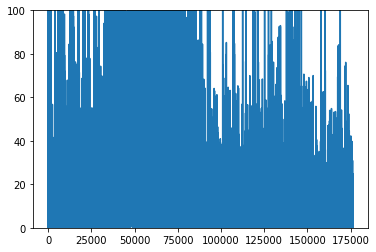

In [54]:
from matplotlib import pyplot as plt 
plt.plot(tlosses)
plt.ylim(0,100)

(0.0, 300.0)

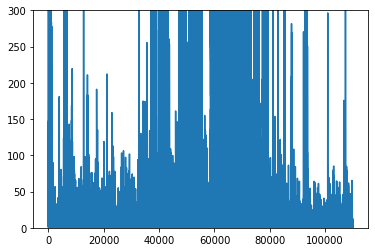

In [47]:
from matplotlib import pyplot as plt 
plt.plot(tlosses)
plt.ylim(0,300)

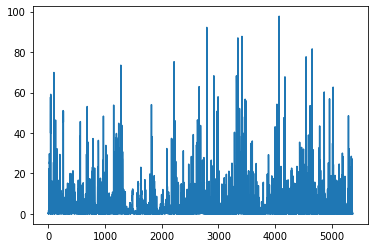

In [24]:
from matplotlib import pyplot as plt 
plt.plot(tlosses)
#plt.ylim(0,50)

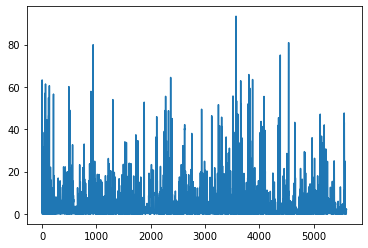

In [22]:
from matplotlib import pyplot as plt 
plt.plot(tlosses)
#plt.ylim(0,50)

In [367]:
z

tensor([[7]], dtype=torch.int32)

In [369]:
xx

NameError: name 'xx' is not defined

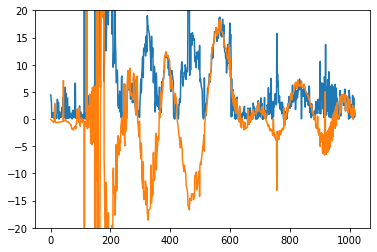

In [298]:
plt.plot(tlosses)
plt.ylim(-20,20)
plt.plot(pks)

(1700.0, 22000.0)

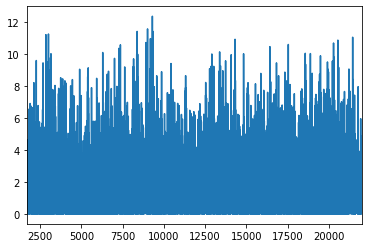

In [379]:
plt.plot(tlosses)
plt.xlim(1700,22000)
#plt.ylim(-20,20)
#plt.plot(pks)

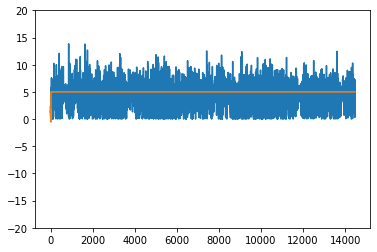

In [372]:
plt.plot(tlosses)
plt.ylim(-20,20)
plt.plot(pks)

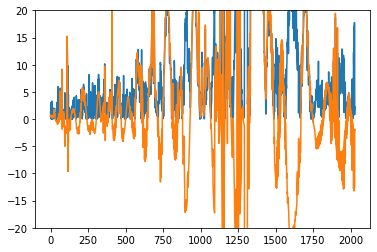

In [358]:
plt.plot(tlosses)
plt.ylim(-20,20)
plt.plot(pks)

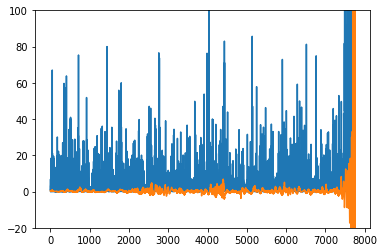

In [14]:
plt.plot(tlosses)
plt.ylim(-20,100)
plt.plot(pks)

(0.0, 50.0)

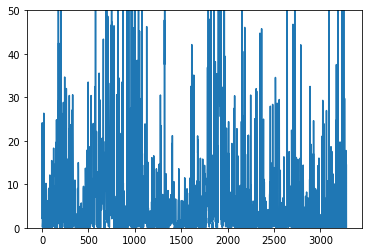

In [7]:
from matplotlib import pyplot as plt 
plt.plot(tlosses)
plt.ylim(0,50)

(0.0, 50.0)

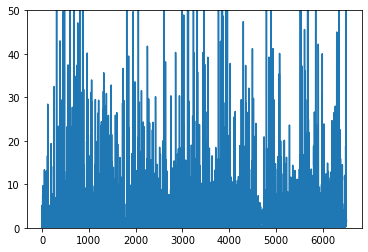

In [17]:
from matplotlib import pyplot as plt 
plt.plot(tlosses)
plt.ylim(0,50)

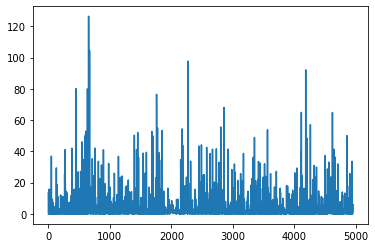

In [10]:
plt.plot(tlosses)

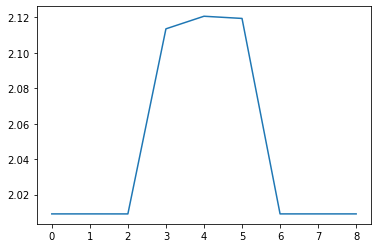

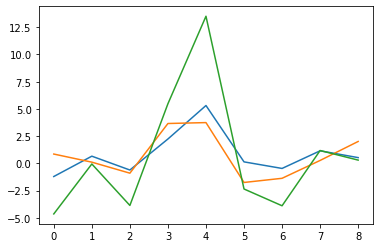

In [332]:
plt.plot(torch.mean(torch.nn.MaxPool2d(3)(x),dim=-1).detach().numpy()[:,2])

plt.show()
plt.plot(torch.mean(x,dim=0).detach().numpy())

In [355]:
torch.median((torch.nn.MaxPool2d(3)(x)))

tensor(2.0091, grad_fn=<MedianBackward0>)

(0.0, 100.0)

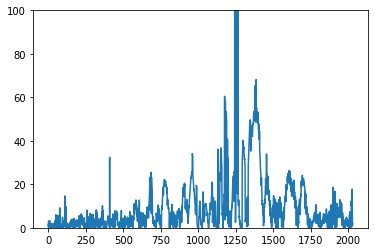

In [360]:
plt.plot(tlosses)
plt.ylim(0,100)

In [329]:
y

-0.3291

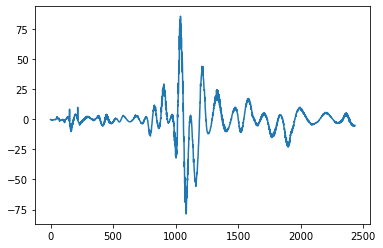

In [275]:
plt.plot(pks)

(-20.0, 20.0)

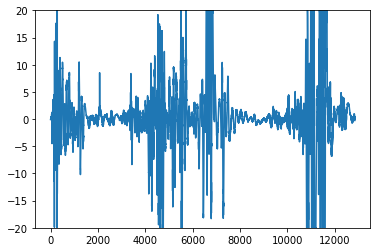

In [292]:
plt.plot(pks)
plt.ylim(-20,20)

(-20.0, 20.0)

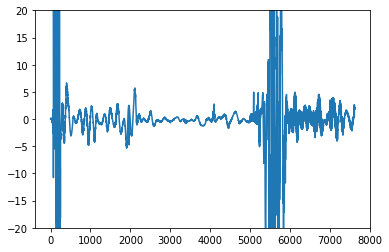

In [282]:
plt.plot(pks)
plt.ylim(-20,20)

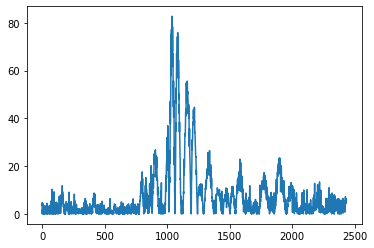

In [276]:
plt.plot(tlosses)
#plt.ylim(0,100)
#plt.plot(pks)

(0.0, 10.0)

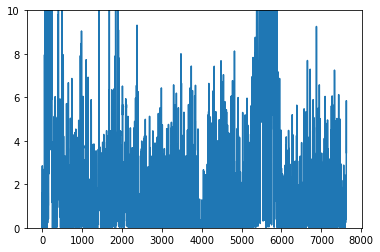

In [285]:
plt.plot(tlosses)
plt.ylim(0,10)
#plt.plot(pks)

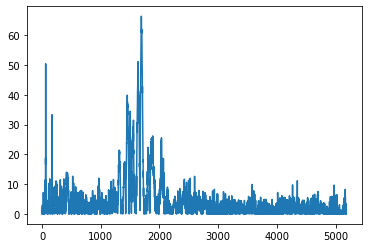

In [278]:
plt.plot(tlosses)
#plt.ylim(0,100)
#plt.plot(pks)

(0.0, 20.0)

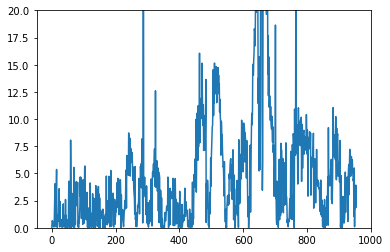

In [271]:
plt.plot(tlosses)
plt.ylim(0,20)
#plt.plot(pks)

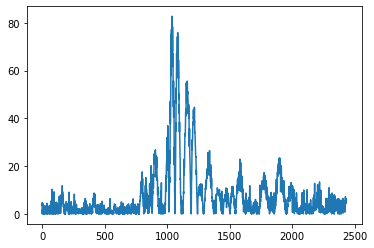

In [274]:
plt.plot(tlosses)
#plt.ylim(0,20)
#plt.plot(pks)

(0.0, 20.0)

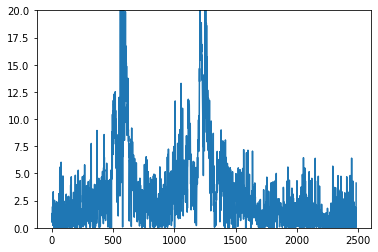

In [246]:
plt.plot(tlosses)
plt.ylim(0,20)
#plt.plot(pks)

(0.0, 20.0)

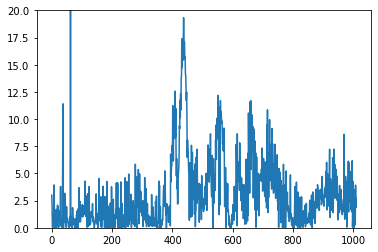

In [248]:
plt.plot(tlosses)
plt.ylim(0,20)
#plt.plot(pks)

(0.0, 20.0)

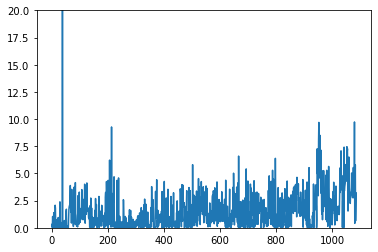

In [251]:
plt.plot(tlosses)
plt.ylim(0,20)
#plt.plot(pks)

(0.0, 20.0)

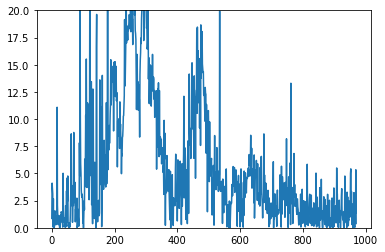

In [255]:
plt.plot(tlosses)
plt.ylim(0,20)
#plt.plot(pks)

(0.0, 10.0)

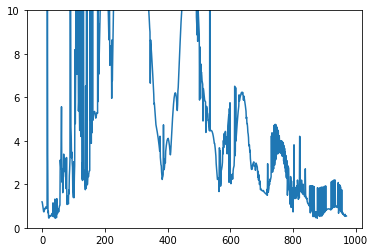

In [258]:
plt.plot(pks)
plt.ylim(0,10)

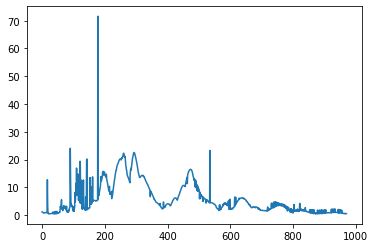

In [256]:
plt.plot(pks)

(0.0, 20.0)

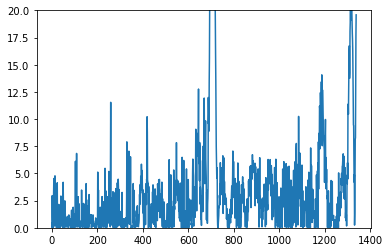

In [260]:
plt.plot(tlosses)
plt.ylim(0,20)
#plt.plot(pks)

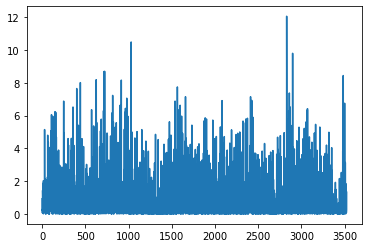

In [242]:
plt.plot(tlosses)
#plt.ylim(0,25)
#plt.plot(pks)

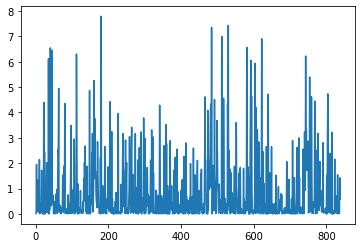

In [263]:
plt.plot(tlosses)
#plt.ylim(0,20)
#plt.plot(pks)

mha added flexibilitz

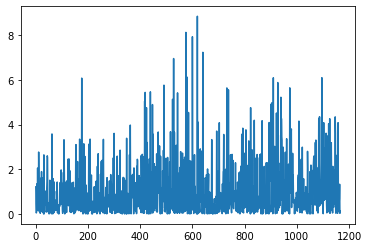

In [234]:
plt.plot(tlosses)
#plt.ylim(0,25)
#plt.plot(pks)

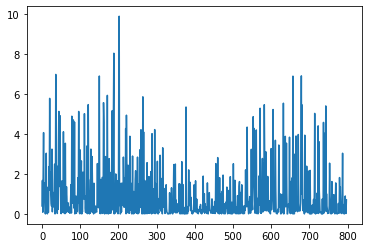

In [236]:
plt.plot(tlosses)
#plt.ylim(0,25)
#plt.plot(pks)

(1700.0, 1900.0)

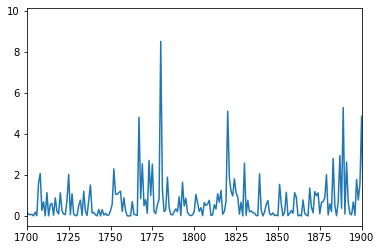

In [240]:
plt.plot(tlosses)
plt.xlim(1700,1900)
#plt.ylim(0,25)
#plt.plot(pks)

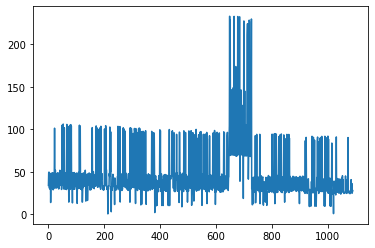

In [195]:
plt.plot(tlosses)
#plt.ylim(0,25)
#plt.plot(pks)

(0.0, 10.0)

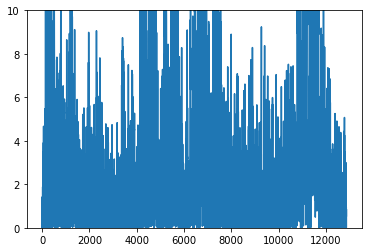

In [290]:
plt.plot(tlosses)
plt.ylim(0,10)
#plt.plot(pks)

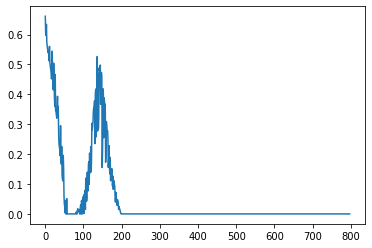

In [237]:
plt.plot(pks)
#plt.ylim(0,)

In [223]:
np.divergence(np.gradient(out.detach().numpy()))

AttributeError: module 'numpy' has no attribute 'divergence'

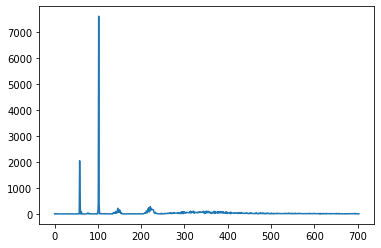

In [199]:
plt.plot(tlosses)
#plt.ylim(0,25)
#plt.plot(pks)

(0.0, 200.0)

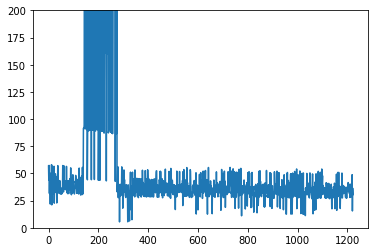

In [203]:
plt.plot(tlosses)
plt.ylim(0,200)
#plt.plot(pks)

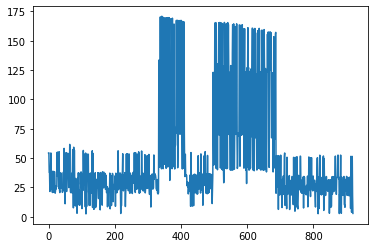

In [197]:
plt.plot(tlosses)
#plt.ylim(0,25)
#plt.plot(pks)

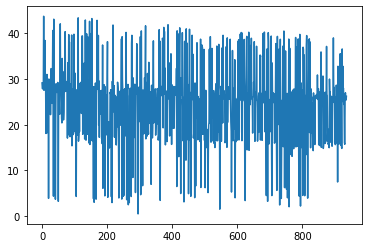

In [207]:
plt.plot(tlosses)
#plt.ylim(0,200)
#plt.plot(pks)

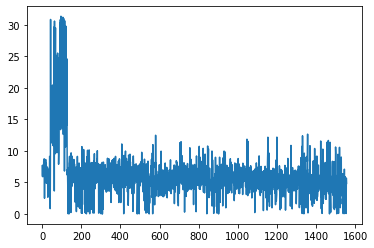

In [211]:
plt.plot(tlosses)
#plt.ylim(0,200)
#plt.plot(pks)

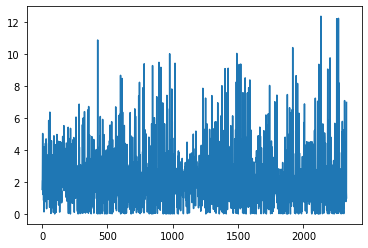

In [213]:
plt.plot(tlosses)
#plt.ylim(0,200)
#plt.plot(pks)
#egnn only

(0.0, 200.0)

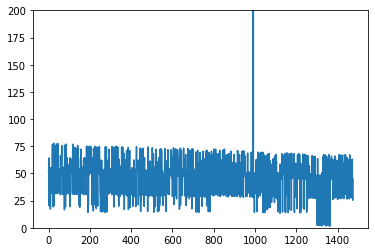

In [216]:
plt.plot(tlosses)
plt.ylim(0,200)
#plt.plot(pks)
#egnn only

(0.0, 200.0)

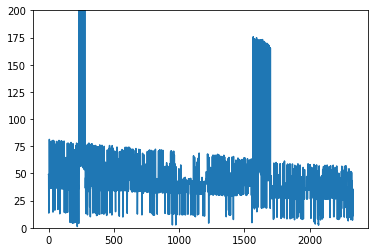

In [218]:
plt.plot(tlosses)
plt.ylim(0,200)
#plt.plot(pks)
#egnn only

In [170]:
torch.sum(pk[0][0,:][5])

tensor(4.1122, grad_fn=<SumBackward0>)

In [168]:
y

0.02363

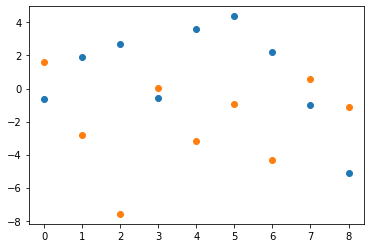

In [133]:
out1[0].shape
from matplotlib import pyplot as plt
plt.plot(out1[0][0].detach().numpy(),"o")

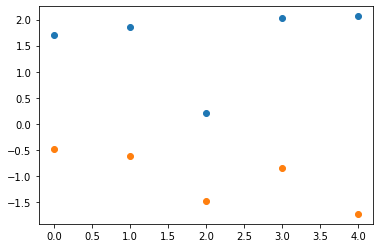

In [224]:
out1[0].shape
from matplotlib import pyplot as plt
plt.plot(out1[0][0].detach().numpy(),"o")

In [229]:
torch.sum(out1[0][0])

tensor(2.7222, grad_fn=<SumBackward0>)

In [11]:
import torch
import torch.nn as nn

class SimpleSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        # x shape: (sequence_length, batch_size, embed_dim)
        attn_output, attn_weights = self.attention(x, x, x)
        return attn_output, attn_weights

# Example usage:
#seq_length, batch_size, embed_dim = 10, 32, 64
#dummy_input = torch.randn(seq_length, batch_size, embed_dim)
model = SimpleSelfAttention(1, num_heads=1)
output, weights = model(out1[0])

print("Output shape:", output.shape)
print("Attention weights shape:", weights.shape)


Output shape: torch.Size([1, 9, 1])
Attention weights shape: torch.Size([9, 1, 1])


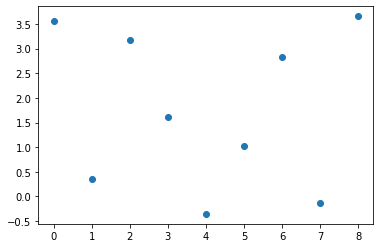

In [14]:
plt.plot(torch.sum(output,dim=0).detach().numpy(),"o")

In [134]:
cos = nn.CosineSimilarity(dim=-1, eps=1e-6)
output = cos(out1[0][0][:,0],out1[0][0][:,1])
output

tensor(-0.5412, grad_fn=<DivBackward0>)

In [135]:
y

-1.41083

In [136]:
out1[0][0][:,0]

tensor([-0.6560,  1.8848,  2.7047, -0.5691,  3.5791,  4.3746,  2.2037, -0.9972,
        -5.1343], grad_fn=<SelectBackward0>)

In [116]:
out.shape

torch.Size([6, 6, 2])

In [69]:
#from torch.signal import bartlett
torch.fft.fft(out[0][0])

tensor([-0.0474+0.j,  0.0037+0.j], grad_fn=<FftR2CBackward0>)

In [99]:
sum(torch.linalg.matrix_norm(out))

tensor(2.1719, grad_fn=<AddBackward0>)

In [78]:
y

2.7318

In [56]:
!pip install igraph

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.1 MB 1.1 MB/s eta 0:00:01


In [63]:
import igraph as ig

# Create a simple weighted graph as an example
g = ig.Graph()
#g.add_vertices(len(out1[0][0]))
#g.add_edges([(0, 1), (1, 2), (0, 3), (3, 4), (4, 2)])
import igraph as ig


g = ig.Graph.Full(len((torch.mean(out1[0][0],dim=0).detach().numpy()))) # creates a complete undirected graph on n vertices
print(g)              
#> IGRAPH U--- 5 10 -- 
#> + edges:
#> 0--1, 0--2, 0--3, 0--4, 1--2, 1--3, 1--4, 2--3, 2--4, 3--4
# Suppose these weights represent travel time or distance:
#g.es['weight'] = [1.0, 1.5, 2.0, 1.0, 2.5]

# Define source and destination
#source = 0
#destination = 2

# Compute the shortest path from source to destination using weights
#path = g.get_shortest_paths(source, to=destination, weights='weight', output="vpath")[0]

# Compute the total weight of the path (i.e., total distance or travel time)
#path_length = sum(g.es[g.get_eids(path=path)]['weight'])
#print("Shortest path (vertex indices):", path)
#print("Total weight (distance or travel time):", path_length)


IGRAPH U--- 2 1 --
+ edges:
0--1


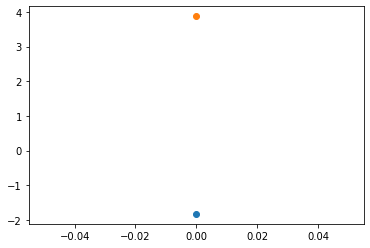

In [54]:
plt.plot(torch.sum(torch.tanh(out1[0]),dim=1).detach().numpy(),"o")

In [37]:
plt.plot(np.mean(np.mean(np.gradient(np.gradient(out1[0][0].detach().numpy()))),axis=0),axis=0)

AxisError: axis 0 is out of bounds for array of dimension 0

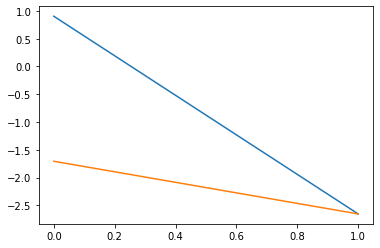

In [51]:
plt.plot(np.mean(np.gradient(np.gradient(out1[0][0].detach().numpy())),axis=2)[1])

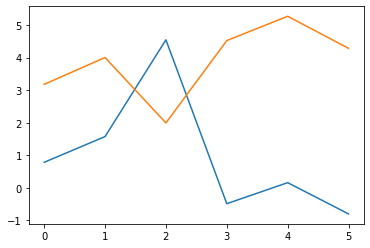

In [104]:
plt.plot(out1[0][0].detach().numpy())

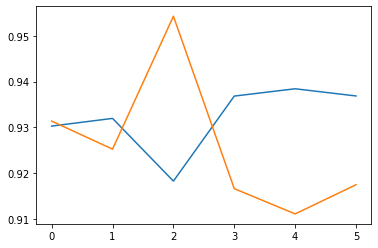

In [143]:
plt.plot(torch.exp(torch.mean(out,dim=0)).detach().numpy())

In [142]:
y

-1.41083

In [43]:
np.mean(np.gradient(np.gradient(out1[0][0].detach().numpy())),axis=0)[1]

array([[ 0.76597923,  0.61497164],
       [ 1.6981636 ,  1.1288384 ],
       [ 1.8147684 ,  1.9526215 ],
       [ 0.44886556,  0.6673562 ],
       [-0.68517923,  0.9303948 ],
       [-8.252769  , -4.1952534 ]], dtype=float32)

In [42]:
y

2.7318

In [7]:
import torch

# Example data: N points of some “symmetric” signal + noise
N =  eleven = 11
x_min, x_max = -5.0, 5.0
x = torch.linspace(x_min, x_max, N)
c = 0.5 * (x_min + x_max)

# f = your measurements f(x); here just random for demo
f = torch.randn(N)

# flip f so that f_flip[i] = f at x_reflected = 2c - x[i]
f_flip = torch.flip(f, dims=[0])

# even (symmetric) and odd (anti-symmetric) parts
f_even = 0.5 * (f + f_flip)
f_odd  = 0.5 * (f - f_flip)

# sanity check: f == f_even + f_odd
recon_error = (f - (f_even + f_odd)).abs().max()
print(f"reconstruction error: {recon_error:.2e}")

# Optionally: visualize with matplotlib
import matplotlib.pyplot as plt
plt.plot(x, f,    'o-', label='original')
plt.plot(x, f_even,'s--',label='even part')
plt.plot(x, f_odd, '^--',label='odd part')
plt.axvline(c, color='gray', lw=1, ls=':')
plt.legend()
plt.show()


-0.47394

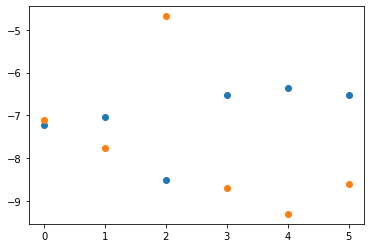

In [105]:
plt.plot(torch.mean(x,dim=0).detach().numpy(),"o")

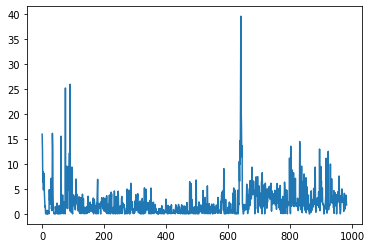

In [112]:
plt.plot(tlosses)

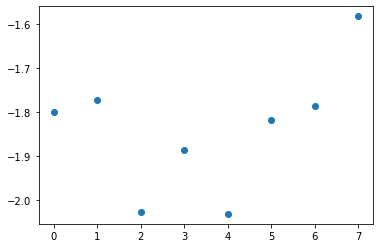

In [50]:
plt.plot(torch.mean(x,dim=0).detach().numpy(),"o")

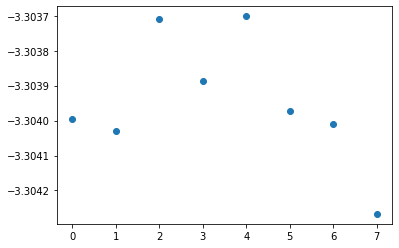

In [53]:
plt.plot(torch.mean(mha(A(out)),dim=0).detach().numpy(),"o")

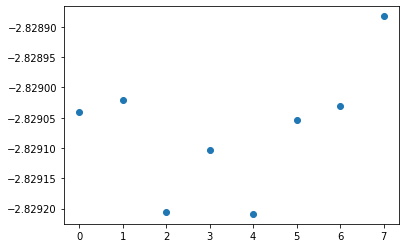

In [56]:
plt.plot(torch.mean(mha(A(mha(A(out)))),dim=0).detach().numpy(),"o")

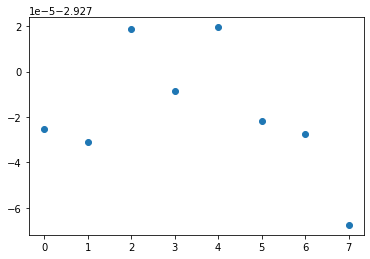

In [58]:
plt.plot(torch.mean(mha(A(mha(A(mha(A(out)))))),dim=0).detach().numpy(),"o")

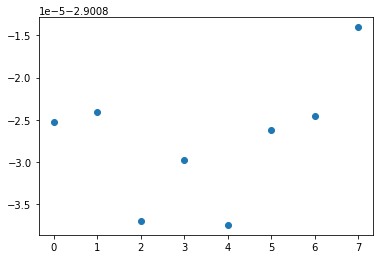

In [59]:
plt.plot(torch.mean(mha(A(mha(A(mha(A(mha(A(out)))))))),dim=0).detach().numpy(),"o")

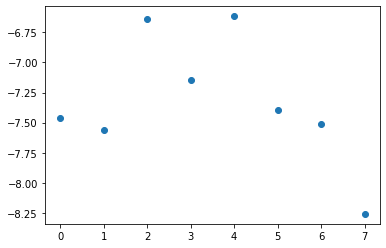

In [72]:
newout=torch.mean(out1[0],dim=0)
from egnn_pytorch import EGNN
y2=EGNN(dim=1)(newout.unsqueeze(0),out1[1])
plt.plot(y2[0][0].detach().numpy(),"o")

In [64]:
newout.shape
out1[1].shape

torch.Size([1, 8, 3])

(-200.0, 200.0)

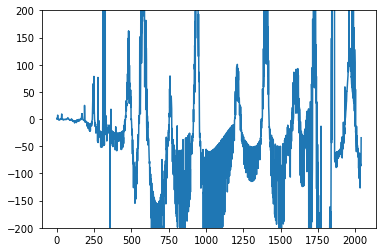

In [5]:
from matplotlib import pyplot as plt
plt.plot(pks)
plt.ylim(-200,200)

(-200.0, 200.0)

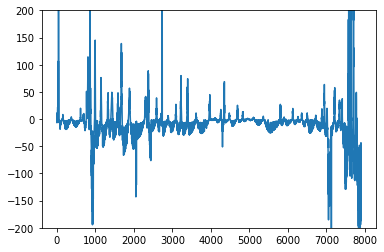

In [10]:
from matplotlib import pyplot as plt
plt.plot(pks)
plt.ylim(-200,200)
down mha dim depth

(-20.0, 20.0)

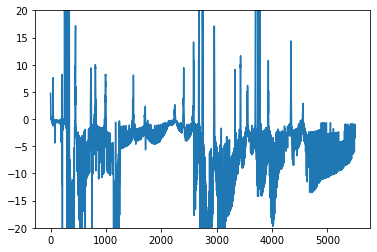

In [16]:
from matplotlib import pyplot as plt
plt.plot(pks)
plt.ylim(-20,20)

ValueError: x and y can be no greater than 2-D, but have shapes (9,) and torch.Size([9, 9, 1])

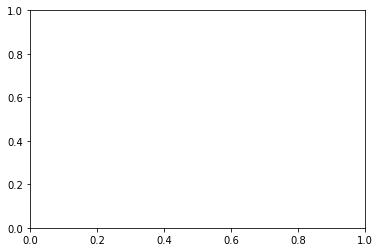

In [17]:
plt.plot(out)